# Filtrando ruído

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
#K.set_image_data_format("channels_first")

from keras.datasets import mnist

import sys
sys.path.append("../src")
from my_keras_utilities import TrainingPlotter

Using TensorFlow backend.


In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [3]:
print(x_train_noisy.shape)
print(x_test_noisy.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


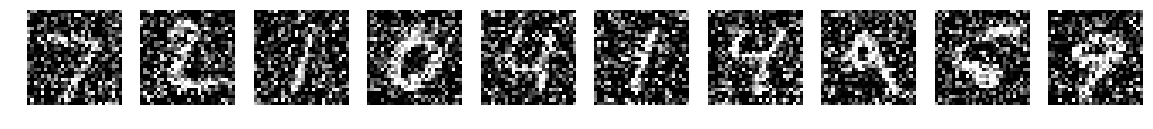

In [4]:
n = 10
plt.figure(figsize=(20, 2))
plt.gray()
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.axis('off')
plt.show()

In [5]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [6]:
testing = True
if testing:
    n_samples = 100
    x_train = x_train[:n_samples]
    x_train_noisy = x_train_noisy[:n_samples]
    
    n_samples_test = 100
    x_test = x_test[:n_samples_test]
    x_test_noisy = x_test_noisy[:n_samples]

100/100 [==============================] - 0s - loss: 0.4530 - val_loss: 0.4345
Epoch 21/100


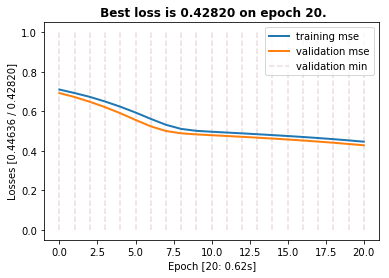

In [7]:
my_big_callback = TrainingPlotter(n=1, patience=15)
fig = plt.figure(figsize=(15,6))
plt.grid(True)
plt.show()


try:
    autoencoder.fit(x_train_noisy[:128], x_train[:128],
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy[:128], x_test[:128]),
                callbacks=[my_big_callback])
except KeyboardInterrupt:
    pass